# Hot Hand Modeling Techniques
## CS109a Final Project
** Tommy, Kyle, Toni, Chip ** 11/24/16

In [1]:
## Load necessary libraries
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
import StringIO
%matplotlib inline

** Description of work within: **

- Load in dataset with proper features
    - Generate previous streak variable
    - Encode other variables as needed
        - Maybe we should add in other player and defender fixed-effects in the future


- Implement baseline model: logit reg of indicator for making shot on streak metric
    - Run this regression for whole dataset
    - Graph logistic function y versus x


- Improve baseline model by adding confounding variables
    - Compare p-values of predictors
    - Interpret Coefficients
    - Compare previous models versus one restricting streak metric to be non-negative
    
    
- Implement robust model for specific players
    - Import top 20 players from previous work
    - Top 20 players selected by generating a score that balances high shot variance and number of shots per game. We want to look at frequen shooters from all over the floor, not just big men or 3-point specialists

In [2]:
## Load in dataset with proper features

# Read in data
data = pd.read_csv('datasets/Augmented_Dataset.csv', index_col=0)
data.columns = map(str.lower, data.columns)

# Generate previous_streak variable
data['previous_streak'] = data.groupby(['player_id', 'game_id'])['current_streak'].apply(lambda x: x.shift(1).fillna(0)).astype(int)

# Preview data
print 'Number of variables:', np.shape(data)[1]
print 'Variable names:', data.columns.values
print 'Number of observations/shots:', np.shape(data)[0]
data.head()

Number of variables: 24
Variable names: ['game_id' 'matchup' 'location' 'w' 'final_margin' 'shot_number' 'period'
 'game_clock' 'shot_clock' 'dribbles' 'touch_time' 'shot_dist' 'pts_type'
 'shot_result' 'closest_defender' 'closest_defender_player_id'
 'close_def_dist' 'fgm' 'pts' 'player_name' 'player_id' 'fg_percent'
 'current_streak' 'previous_streak']
Number of observations/shots: 118033


,game_id,matchup,location,w,final_margin,shot_number,period,game_clock,shot_clock,dribbles,...,closest_defender,closest_defender_player_id,close_def_dist,fgm,pts,player_name,player_id,fg_percent,current_streak,previous_streak
28621,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,1,1,2:29,22.1,0,...,"Roberts, Brian",203148,4.4,1,3,ryan anderson,201583,0.407407,1,0
28622,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,2,2,11:19,5.8,2,...,"Zeller, Cody",203469,6.1,1,2,ryan anderson,201583,0.407407,2,1
28623,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,3,2,10:51,10.2,2,...,"Maxiell, Jason",101131,5.7,0,0,ryan anderson,201583,0.407407,-1,2
28624,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,4,2,8:21,24.0,0,...,"Zeller, Cody",203469,2.6,1,2,ryan anderson,201583,0.407407,1,-1
28625,21400054,"NOV 04, 2014 - NOP vs. CHA",H,W,9,5,2,7:59,16.0,0,...,"Zeller, Cody",203469,6.5,0,0,ryan anderson,201583,0.407407,-1,1


In [3]:
## Data manipulation/cleaning

# Convert categorical variable into dummy/indicator variables
encoding = pd.get_dummies(data['w'])
data = pd.concat((data, encoding), axis=1)
data.drop('L', axis=1, inplace=True)

## Impute missing 'shot_clock' vals


old_clock = data['game_clock'].values
new_time = []

# loop through and make new_time array
for x in old_clock:
    minutes, seconds = x.split(':')
    minutes, seconds = float(minutes), float(seconds)
    new_time.append(minutes*60 + seconds)
    
# create new predictor column
data['game_clock'] = new_time

In [4]:
# fill missing 'shot_clock' vals
for index, row in data.iterrows():
    if pd.isnull(row['shot_clock']):
        # Impute missing 'shot_clock' val as the game_clock value, since the shot clock was turned off in this case
        data.set_value(index, 'shot_clock', row['game_clock'])

In [5]:
## Implement baseline model: logit reg of indicator for making shot on streak metric
    # Run this regression for top 20 players
    # Assess model's quality
    
# Split x and y
x = data['previous_streak']
x = x.reshape(-1, 1)
y = data['fgm'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6, random_state=42)

# Fit model
baseline_logit = LogisticRegression()
baseline_logit.fit(x_train, y_train)

# Print coefficients
coef = baseline_logit.coef_[0][0]
print 'Coefficient on streak predictor:', coef

# Score model
score = baseline_logit.score(x_test, y_test)
print 'Classification rate:', score
print 'Percentage of field goals made:', y.mean()

Coefficient on streak predictor: -0.00836280125822
Classification rate: 0.546130385055
Percentage of field goals made: 0.454627095812


** Discussion: **

Even without any other predictors the coefficient on the streak predictor is a pretty precisely estimated 0. Furthermore, the model barely performs any better than 50% i.e. the model is not much better than flipping a coin, so in this situation the hot hand theory looks weak.

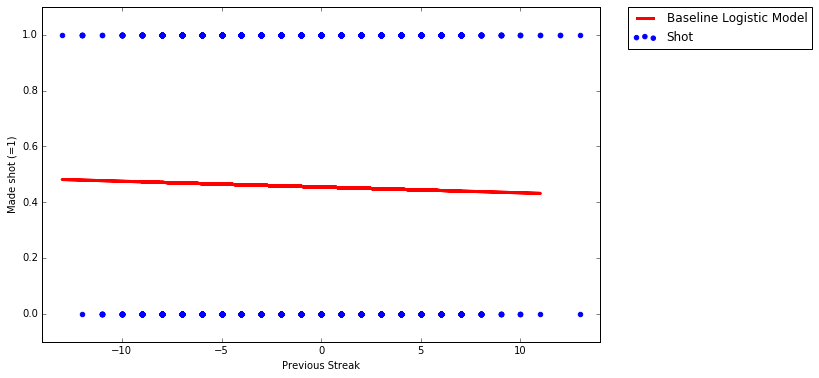

In [6]:
## Graph y as a function of x

# Fit model
clf = LogisticRegression()
clf.fit(x_train, y_train)

# Plot the result
plt.figure(1, figsize=(10, 6))
plt.clf()
plt.scatter(x.ravel(), y, color='blue', zorder=20)
def model(x):
    return 1 / (1 + np.exp(-x))
loss = model(x_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(x_test, loss, color='red', linewidth=3)

plt.ylabel('Made shot (=1)')
plt.xlabel('Previous Streak')
plt.ylim(-0.1, 1.1)
plt.xlim(-14, 14)
plt.legend(('Baseline Logistic Model', 'Shot'),
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('website reports/baseline_logit.png', dpi=100, bbox_inches='tight', pad_inches=0.2)
plt.show()

Even the graph of the model shows a pretty useless and nondescriminant model.

The above shows the distribution of the $previous\_streak$ variable depending on whether the shot is missed or made. The distributions appear to be almost identical whether the shot is missed or made with the quantity of shots missed being greater than the amount made at about each value of $previous\_streak$.

If $previous\_streak$ were more likely to be associated with a made shot, then we would see the made distribution more shifted to the right and the missed distribution more shifted to the left in the above figure, but this is obviously not the case and is what is driving the above results in the baseline model.

In [7]:
## Using statsmodels

# Fit the model
logit = sm.Logit(data['fgm'], data['previous_streak'])
result = logit.fit()

# Print results
result.summary()
text_file = open("website reports/baseline_model.csv", "w")
text_file.write(result.summary().as_csv())
text_file.close()
result.summary()

Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    fgm   No. Observations:               118033
Model:                          Logit   Df Residuals:                   118032
Method:                           MLE   Df Model:                            0
Date:                Wed, 14 Dec 2016   Pseudo R-squ.:               -0.005983
Time:                        01:17:14   Log-Likelihood:                -81814.
converged:                       True   LL-Null:                       -81328.
                                        LLR p-value:                       nan
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
previous_streak     0.0009      0.003      0.319      0.750        -0.005     0.007
===================================================================================
"""

** Wow. ** P-value is huge and standard error is huge relative to the actual estimate of the coefficient. Seems pretty unlikely that the previous_streak variable is going to have much prediction power.

In [8]:
## Checking for confounding variables
    # One by one, add in what you believe could be confounding variables 
    # and see if the ‘streak’ metric turns/still is significant.

# Create array of possible confounders
possible_confounders = ['previous_streak', 'final_margin', 'dribbles', 'touch_time', 'shot_dist', 'close_def_dist', 
                        'fg_percent', 'shot_clock']

# Choose x_set
x = data[possible_confounders]
y = data['fgm'].values

# Look at results
logit = sm.Logit(y, x)
result = logit.fit()
result.summary()
text_file = open("website reports/robust_model.csv", "w")
text_file.write(result.summary().as_csv())
text_file.close()
result.summary()

Optimization terminated successfully.
         Current function value: 0.660258
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               118033
Model:                          Logit   Df Residuals:                   118025
Method:                           MLE   Df Model:                            7
Date:                Wed, 14 Dec 2016   Pseudo R-squ.:                 0.04175
Time:                        01:17:15   Log-Likelihood:                -77932.
converged:                       True   LL-Null:                       -81328.
                                        LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
previous_streak    -0.0094      0.003     -3.133      0.002        -0.015    -0.004
final_margin        0.0092      0.000     19.886      0.000         0.008     0.010
dribbles            0.0330      0.005      7.067      0.000         0.024     0.042
touch_time         -0.0678      0.005    -12.488      0.000        -0.078    -0.057
shot_dist          -0.0615      0.001    -74.267      0.000        -0.063    -0.060
close_def_dist      0.1049      0.003     37.026      0.000         0.099     0.110
fg_percent          0.7319      0.030     24.024      0.000         0.672     0.792
shot_clock          0.0001      0.000      1.278      0.201     -7.95e-05     0.000
===================================================================================
"""

In [9]:
## Score model

# Split robust predictors
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.6, random_state=42)

# Fit model
robust_logit = LogisticRegression(C=100000000.0)
robust_logit.fit(x_train, y_train)

# Score and print
score = robust_logit.score(x_test, y_test)
print 'Classification rate:', score

Classification rate: 0.606387935782


** Important! **

By adding other predictors, the streak variable does become significant, albeit just barely and the sign of the coefficient is the opposite of what we might expect. I.e., the coefficient is a very small negative term indicating that each additional shot made in a streak will decrease the log-likelihood of making the next shot.

In [10]:
## Interpreting coefficient

print 'Coefficient odds ratio and 95% CI:'
print ''
params = result.params
conf = result.conf_int()
conf['Estimated coefficient'] = params
conf.columns = ['2.5%', '97.5%', 'Estimated coefficient']
print np.exp(conf)


Coefficient odds ratio and 95% CI:

                     2.5%     97.5%  Estimated coefficient
previous_streak  0.984874  0.996496               0.990668
final_margin     1.008290  1.010112               1.009201
dribbles         1.024161  1.043102               1.033588
touch_time       0.924537  0.944429               0.934430
shot_dist        0.938799  0.941853               0.940325
close_def_dist   1.104412  1.116741               1.110560
fg_percent       1.958593  2.207043               2.079110
shot_clock       0.999921  1.000377               1.000149


** Interpreting coefficients **

The above shows us that the exponential of the produced coefficients from the logistic regression. This tells us how a 1 unit increase in a variable affects the odds of making the shot.

So for the above, an increase in one's streak by one shot, actually decreases the odds of making the next shot by less than 1 percent. This is *such* a small effect. It is, again, actually impressive how small of an effect this is.

In [11]:
## Only positive streaks

# Restrict data set to where previous_streak>=0
positive_streak_data = data[data['previous_streak']>=0]

# Only streak metric
y = positive_streak_data['fgm'].values
x = positive_streak_data['previous_streak']

# Look at results
logit = sm.Logit(y, x)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.689783
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                60242
Model:                          Logit   Df Residuals:                    60241
Method:                           MLE   Df Model:                            0
Date:                Wed, 14 Dec 2016   Pseudo R-squ.:               -0.002912
Time:                        01:17:15   Log-Likelihood:                -41554.
converged:                       True   LL-Null:                       -41433.
                                        LLR p-value:                       nan
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
previous_streak    -0.0929      0.005    -19.993      0.000        -0.102    -0.084
===================================================================================
"""

In [12]:
# Use more robust x
x = positive_streak_data[possible_confounders]

# Look at results
logit = sm.Logit(y, x)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.659517
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                60242
Model:                          Logit   Df Residuals:                    60234
Method:                           MLE   Df Model:                            7
Date:                Wed, 14 Dec 2016   Pseudo R-squ.:                 0.04109
Time:                        01:17:15   Log-Likelihood:                -39731.
converged:                       True   LL-Null:                       -41433.
                                        LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
previous_streak    -0.0175      0.007     -2.349      0.019        -0.032    -0.003
final_margin        0.0087      0.001     13.614      0.000         0.007     0.010
dribbles            0.0475      0.006      7.311      0.000         0.035     0.060
touch_time         -0.0826      0.008    -10.876      0.000        -0.097    -0.068
shot_dist          -0.0607      0.001    -52.595      0.000        -0.063    -0.058
close_def_dist      0.1008      0.004     25.320      0.000         0.093     0.109
fg_percent          0.8014      0.048     16.803      0.000         0.708     0.895
shot_clock      -9.688e-05      0.000     -0.620      0.536        -0.000     0.000
===================================================================================
"""

** Comment: **

Even after restricting to just the positive streaks, the streak metric still has a negative coefficient, and a slightly larger one at that.

In [13]:
## Define function which takes as input player_name, runs logit model on them,
    # prints coef on previous_streak, std err, p-val, and r^2
    
def player_hothand_logit(player_name):
    
    # Get player data
    player_data = data[data['player_name']==player_name]
    
    # Set x and y
    y = player_data['fgm'].values
    x = player_data[possible_confounders]

    # Fit model
    logit = sm.Logit(y, x)
    result = logit.fit(disp=0)
    
    # Return params
    print player_name, '- Individual Hot Hand Effect:'
    print 'Hot Hand Coef:', result.params.previous_streak
    print 'Odds ratio effect:', np.exp(result.params.previous_streak)
    print 'Std Err:', result.bse.previous_streak
    print 'p:', result.pvalues.previous_streak
    print 'Pseudo R^2:', result.prsquared

In [14]:
## For individual players

# Crate player_name_array
player_name_array = data['player_name'].unique()

# Loop through players
for i in range(5):
    # Run model
    player_hothand_logit(player_name_array[i])
    print ''

ryan anderson - Individual Hot Hand Effect:
Hot Hand Coef: 0.0155225543334
Odds ratio effect: 1.01564365497
Std Err: 0.0386633091907
p: 0.688066589584
Pseudo R^2: 0.0376932462166

chandler parsons - Individual Hot Hand Effect:
Hot Hand Coef: -0.00685506089187
Odds ratio effect: 0.993168381441
Std Err: 0.0373998792292
p: 0.854569703538
Pseudo R^2: 0.0483884648879

kirk hinrich - Individual Hot Hand Effect:
Hot Hand Coef: -0.0715273498656
Odds ratio effect: 0.93097081532
Std Err: 0.0765831969305
p: 0.350313027011
Pseudo R^2: 0.070168131309

kentavious caldwell-pope - Individual Hot Hand Effect:
Hot Hand Coef: -0.0234773307631
Odds ratio effect: 0.97679611764
Std Err: 0.0412546214115
p: 0.569299369679
Pseudo R^2: 0.0551029737229

kevin love - Individual Hot Hand Effect:
Hot Hand Coef: 0.0218567771623
Odds ratio effect: 1.0220973863
Std Err: 0.0366094464744
p: 0.550490281405
Pseudo R^2: 0.0383766012321



In [15]:
## Players of note
players_sorted = pd.read_csv('datasets/df_score.csv')
key_players = players_sorted.iloc[:,0].values[:20]

# Loop through players
for player in key_players:
    
    # Run function
    player_hothand_logit(player)
    print ''

lebron james - Individual Hot Hand Effect:
Hot Hand Coef: -0.0518708750513
Odds ratio effect: 0.949451456799
Std Err: 0.034184612708
p: 0.129172044381
Pseudo R^2: 0.0884803593128

damian lillard - Individual Hot Hand Effect:
Hot Hand Coef: 0.0305742331866
Odds ratio effect: 1.03104642507
Std Err: 0.0311542690196
p: 0.326404488629
Pseudo R^2: 0.0544005122004

russell westbrook - Individual Hot Hand Effect:
Hot Hand Coef: -0.0378322421488
Odds ratio effect: 0.962874457093
Std Err: 0.0329117871846
p: 0.250348078918
Pseudo R^2: 0.0634705664871

james harden - Individual Hot Hand Effect:
Hot Hand Coef: 0.0179319473372
Odds ratio effect: 1.01809369005
Std Err: 0.0277101139929
p: 0.517550116461
Pseudo R^2: 0.0409083885707

carmelo anthony - Individual Hot Hand Effect:
Hot Hand Coef: -0.052225542286
Odds ratio effect: 0.949114777184
Std Err: 0.036797643073
p: 0.155822283712
Pseudo R^2: 0.0426707667339

stephen curry - Individual Hot Hand Effect:
Hot Hand Coef: -0.0734296630733
Odds ratio effec

## Conclusion: ##

** Streak metric is generally a poor predictor ** or it has very little predictive significance. From our robust model on the whole dataset, the streak metric is significant, but very small in relative magnitude. For an increase in streak of one unit, this only affects the probability of making the next shot by about or less than 1%. Furthermore, this effect on probability is a decrease, i.e. the exact opposite of what we expect to see if the hot hand were true. If anything, a shooter on a streak becomes less likely to make their next shot.

** These results hold true if the data is restricted to observations where the streak metric is non-negative. **

** The hot hand effect varies for our top 20 players. ** If we fit models for individual players, the hot hand effect varies in both magnitude and sign. There is about an equal distribution of negative and positive estimated coefficients which resonates with our finding that the streak metric is generally an estimated zero when the model is run on the whole dataset. Unfortunately, most of these estimates have p-values greater than .05 or .1 indicating that our estimates are not significant. Interestingly enough though is that the only player to have a significant estimate is Steph Curry (likely because he takes a large amount of shots). Steph's hot hand effect is estimated to be a negative coefficient though that implies as Steph makes an additional shot in a streak, his probability of making the next shot decreases by about 8% (which is pretty significant in magnitude). The player with the largest positive hot hand effect is Derrick Rose whose probability of making the next shot increases by about 5% for each additional shot he makes in a streak.

** Comment on next steps: ** These are some pretty interesting results I think. There are a number of ways in which we can move forward. We can try to improve the quality of our model by adding in more predictors. Having a predictor to encapsulate defender quality sticks out to me as the most important one to add. We could also try to analyze what determines who has a high individual hot hand effect. Why does Derek Rose have such a hot hand while Steph only gets colder as he makes more shots? Definitely plenty of cool work left to be done I think. Next steps more concretely discussed in our Milestone 5 Report.
